In [1]:
# import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import the demographic data
demographic_data = pd.read_csv('funcs/tsv/master_participants_list_0to11.tsv', sep='\t')
# Map the sex column to a categorical variable
demographic_data['sex'] = demographic_data['sex'].map({'M': 'Male', 'F': 'Female'})

/var/folders/yh/v431j0015bq2_32ydhg5kvnm0000gn/T/ipykernel_76097/2595402620.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  availability_summary = demographic_data.groupby('release_number').apply(lambda df: df.loc[:, task_columns].apply(pd.Series.value_counts).T.fillna(0))


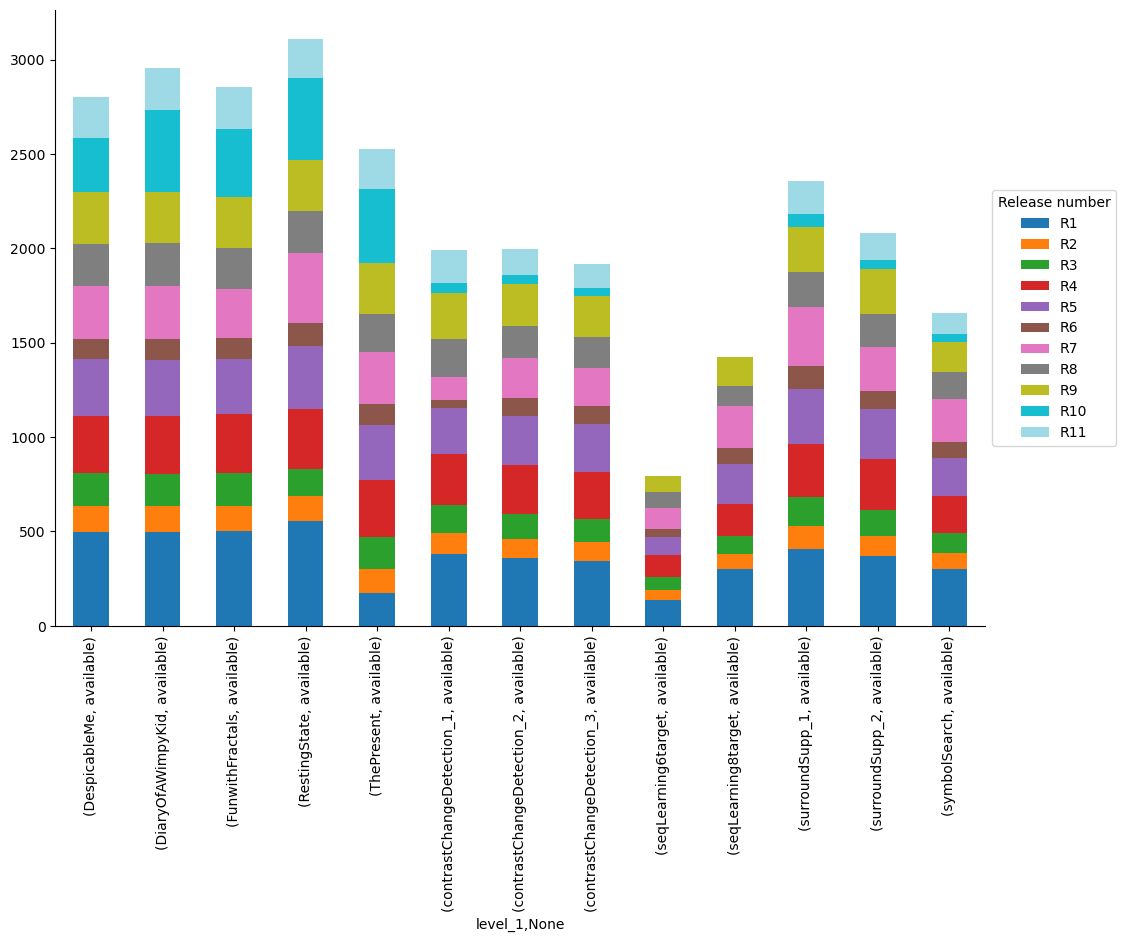

In [2]:
# make stacked bar plot of the tasks marked as available
# tasks are listed in the columns 11 to last column of the demographic data
excluded_columns = ['participant_id', 'release_number', 'sex', 'age', 'ehq_total', 'commercial_use', 'full_pheno', 'p_factor', 'attention', 'internalizing', 'externalizing']
task_columns = [col for col in demographic_data.columns if col not in excluded_columns]

# Count the availability status for each task across releases
availability_summary = demographic_data.groupby('release_number').apply(lambda df: df.loc[:, task_columns].apply(pd.Series.value_counts).T.fillna(0))

# Reset index for better visualization
availability_summary = availability_summary.reset_index()

# Melt, so X axis becomes tasks and Y axis becomes counts, with different colors for each release
plot_data = availability_summary.set_index(['release_number', 'level_1']).stack().unstack(level=0)

# add categorical index to make the plot order from R1, R2 to R11
plot_data.columns = pd.CategoricalIndex(plot_data.columns.values, categories=[f'R{i}' for i in range(1, 12)], ordered=True)
plot_data = plot_data.sort_index(axis=1)
# Plot the stacked bar plot only for the tasks that are available
# plot only the tasks that are available, mentioned in the index
plot_data = plot_data.loc[plot_data.index.get_level_values(level=1) == 'available', :]
fig, ax = plt.subplots(figsize=(12, 8))
plot_data.plot(kind='bar', stacked=True, ax=ax, colormap='tab20')
# remove the right and top spines
sns.despine()
# set th legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Release number')

# save the plot
# plt.savefig('funcs/availability_summary.pdf', bbox_inches='tight')
plt.show()

In [3]:
# Calculate the total number of participants per release
total_participants = demographic_data.groupby('release_number').size()

# Calculate the number of participants with at least one task marked as available
participants_with_available_task = demographic_data[task_columns].apply(lambda row: (row == 'available').any(), axis=1)
participants_with_available_task_count = demographic_data[participants_with_available_task].groupby('release_number').size()

# Create the summary table
summary_table = pd.DataFrame({
    'Total Participants': total_participants,
    'Participants with Available Task': participants_with_available_task_count
}).reset_index()

# add total as the last row only for the last two columns
summary_table.loc['Total'] = summary_table.iloc[:, 1:].sum()

print(summary_table)

      release_number  Total Participants  Participants with Available Task
0                 R1               578.0                             578.0
1                R10               533.0                             490.0
2                R11               430.0                             240.0
3                 R2               154.0                             152.0
4                 R3               185.0                             183.0
5                 R4               324.0                             324.0
6                 R5               330.0                             330.0
7                 R6               135.0                             134.0
8                 R7               381.0                             381.0
9                 R8               257.0                             257.0
10                R9               295.0                             295.0
Total            NaN              3602.0                            3364.0


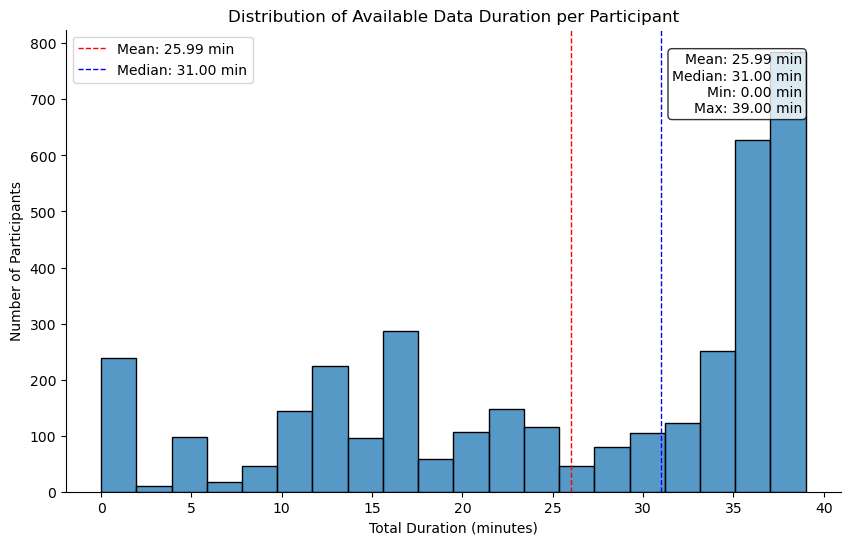

Duration Summary by Release Number:
   release_number  count       mean  median  min   max
0              R1    578  27.778547    34.0  3.0  39.0
1             R10    533  13.318949    13.0  0.0  34.0
2             R11    430  14.104651    14.0  0.0  34.0
3              R2    154  30.525974    37.0  0.0  39.0
4              R3    185  31.537838    37.0  0.0  39.0
5              R4    324  34.240741    37.0  5.0  39.0
6              R5    330  33.519697    37.0  3.5  39.0
7              R6    135  30.088889    34.0  0.0  39.0
8              R7    381  27.527559    31.0  3.5  39.0
9              R8    257  29.614786    34.0  3.0  39.0
10             R9    295  32.367797    37.0  3.0  39.0


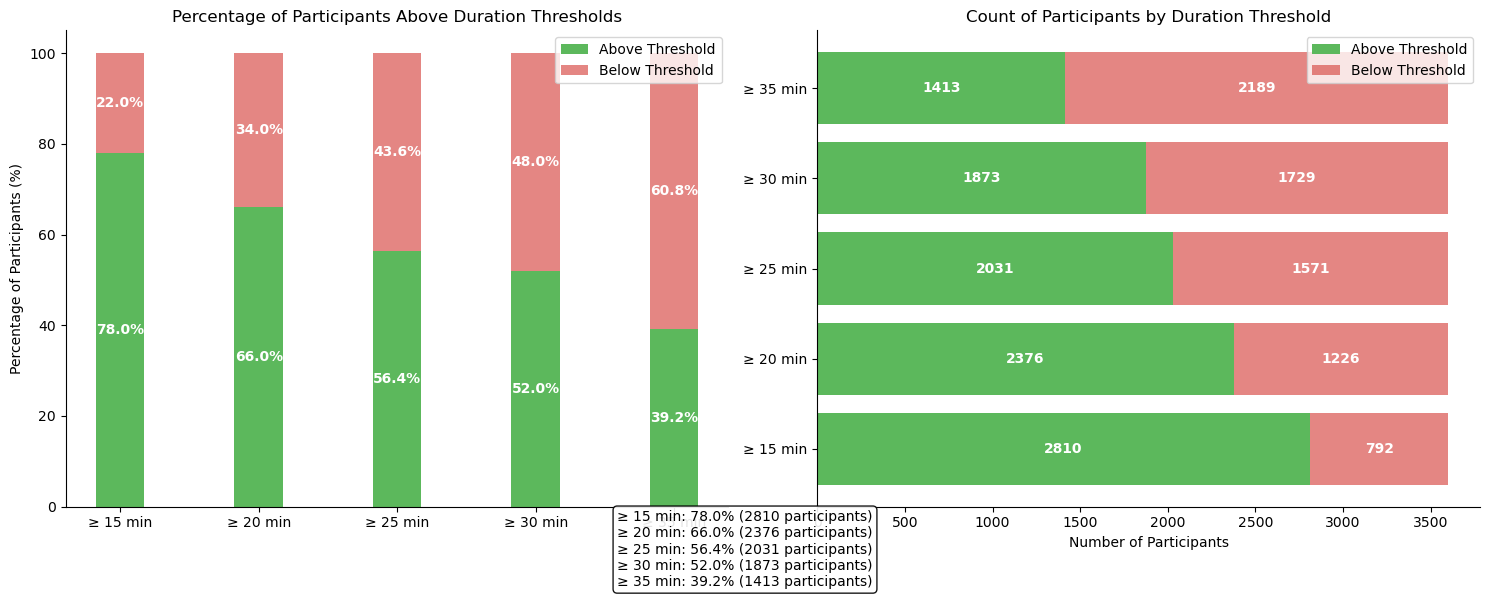


Percentage and count of participants above duration thresholds:
≥ 15 minutes: 78.01% (2810 out of 3602 participants)
≥ 20 minutes: 65.96% (2376 out of 3602 participants)
≥ 25 minutes: 56.39% (2031 out of 3602 participants)
≥ 30 minutes: 52.00% (1873 out of 3602 participants)
≥ 35 minutes: 39.23% (1413 out of 3602 participants)


In [12]:
# Add task duration per subject
# Duration of each task in the following dictionary  for each of the task_columns
task_durations = {
    'RestingState': 5,
    'DespicableMe': 3,
    'FunwithFractals': 3,
    'ThePresent': 3,
    'DiaryOfAWimpyKid':2,
    'contrastChangeDetection_1':3,
    'contrastChangeDetection_2':3,
    'contrastChangeDetection_3':3,
    'surroundSupp_1':3.5,
    'surroundSupp_2':3.5,
    'seqLearning6target':5,
    'seqLearning8target':5,
    'symbolSearch':2
    }
# Calculate total duration of available data for each participant
def calculate_total_duration(row):
    total_minutes = 0
    for task, duration in task_durations.items():
        if task in task_columns and row[task] == 'available':
            total_minutes += duration
    return total_minutes

# Apply the function to each row in the demographic data
demographic_data['total_duration_minutes'] = demographic_data.apply(calculate_total_duration, axis=1)

# Create a histogram of total duration minutes
plt.figure(figsize=(10, 6))
sns.histplot(data=demographic_data, x='total_duration_minutes', bins=20)
plt.title('Distribution of Available Data Duration per Participant')
plt.xlabel('Total Duration (minutes)')
plt.ylabel('Number of Participants')

# Add summary statistics
mean_duration = demographic_data['total_duration_minutes'].mean()
median_duration = demographic_data['total_duration_minutes'].median()
plt.axvline(mean_duration, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_duration:.2f} min')
plt.axvline(median_duration, color='blue', linestyle='dashed', linewidth=1, label=f'Median: {median_duration:.2f} min')
plt.legend()

# Add a text box with summary statistics
stats_text = (f"Mean: {mean_duration:.2f} min\n"
              f"Median: {median_duration:.2f} min\n"
              f"Min: {demographic_data['total_duration_minutes'].min():.2f} min\n"
              f"Max: {demographic_data['total_duration_minutes'].max():.2f} min")
plt.text(0.95, 0.95, stats_text, transform=plt.gca().transAxes, 
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

sns.despine()
plt.show()

# Create a summary table of duration distribution by release number
duration_summary = demographic_data.groupby('release_number')['total_duration_minutes'].agg(['count', 'mean', 'median', 'min', 'max']).reset_index()
print("Duration Summary by Release Number:")
print(duration_summary)

# Calculate percentiles for different duration thresholds
thresholds = [15, 20, 25, 30, 35]
percentiles = {}
counts = {}

for threshold in thresholds:
    above_threshold = (demographic_data['total_duration_minutes'] >= threshold).mean() * 100
    percentiles[threshold] = above_threshold
    
    count_above = (demographic_data['total_duration_minutes'] >= threshold).sum()
    total_count = len(demographic_data)
    counts[threshold] = (count_above, total_count)

# Create a more visually appealing plot with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# First subplot: Bar chart with percentage and count
x = np.arange(len(thresholds))
width = 0.35

# Calculate percentages below threshold for stacked bars
below_percentages = [100 - percentiles[t] for t in thresholds]

# Create stacked bars for the first subplot
ax1.bar(x, [percentiles[t] for t in thresholds], width, label='Above Threshold', color='#5cb85c')
ax1.bar(x, below_percentages, width, bottom=[percentiles[t] for t in thresholds], 
       label='Below Threshold', color='#d9534f', alpha=0.7)

# Add percentage labels on the bars
for i, threshold in enumerate(thresholds):
    percentage = percentiles[threshold]
    ax1.text(i, percentage/2, f'{percentage:.1f}%', 
            ha='center', va='center', color='white', fontweight='bold')
    ax1.text(i, percentage + below_percentages[i]/2, f'{100-percentage:.1f}%', 
            ha='center', va='center', color='white', fontweight='bold')

ax1.set_ylabel('Percentage of Participants (%)')
ax1.set_title('Percentage of Participants Above Duration Thresholds')
ax1.set_xticks(x)
ax1.set_xticklabels([f'≥ {t} min' for t in thresholds])
ax1.legend(loc='upper right')

# Second subplot: Count visualization
for i, threshold in enumerate(thresholds):
    count_above, total_count = counts[threshold]
    count_below = total_count - count_above
    
    # Create horizontal stacked bar
    ax2.barh(i, count_above, color='#5cb85c', label='Above Threshold' if i == 0 else "")
    ax2.barh(i, count_below, left=count_above, color='#d9534f', alpha=0.7, 
            label='Below Threshold' if i == 0 else "")
    
    # Add count labels
    ax2.text(count_above/2, i, f'{count_above}', 
            ha='center', va='center', color='white', fontweight='bold')
    ax2.text(count_above + count_below/2, i, f'{count_below}', 
            ha='center', va='center', color='white', fontweight='bold')

ax2.set_yticks(np.arange(len(thresholds)))
ax2.set_yticklabels([f'≥ {t} min' for t in thresholds])
ax2.set_xlabel('Number of Participants')
ax2.set_title('Count of Participants by Duration Threshold')
ax2.legend(loc='upper right')

# Add a text box with detailed statistics to the figure
stats_text = "\n".join([f"≥ {threshold} min: {percentage:.1f}% ({counts[threshold][0]} participants)" 
                      for threshold, percentage in percentiles.items()])
fig.text(0.5, 0.01, stats_text, ha='center', va='bottom',
       bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

plt.tight_layout(rect=[0, 0.05, 1, 1])  # Adjust layout to make room for the text
sns.despine(fig)
plt.show()

# Print detailed statistics
print("\nPercentage and count of participants above duration thresholds:")
for threshold in thresholds:
    percentage = percentiles[threshold]
    count_above, total_count = counts[threshold]
    print(f"≥ {threshold} minutes: {percentage:.2f}% ({count_above} out of {total_count} participants)")



In [4]:
print(task_columns)

['RestingState', 'DespicableMe', 'FunwithFractals', 'ThePresent', 'DiaryOfAWimpyKid', 'contrastChangeDetection_1', 'contrastChangeDetection_2', 'contrastChangeDetection_3', 'surroundSupp_1', 'surroundSupp_2', 'seqLearning6target', 'seqLearning8target', 'symbolSearch']


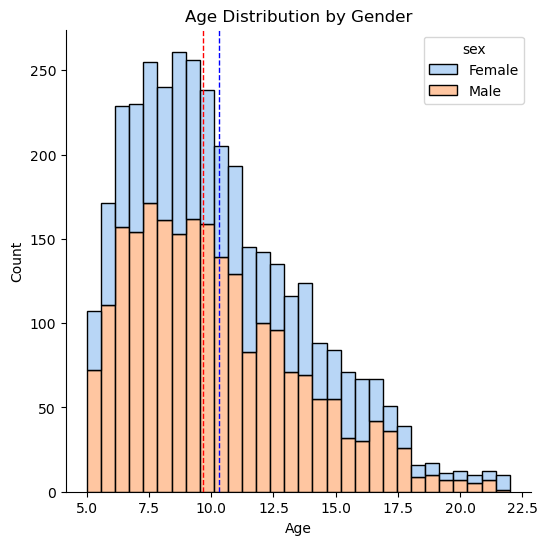

In [5]:
# Create a histogram with 'age' on the x-axis and 'sex' as hue
plt.figure(figsize=(6, 6))
sns.histplot(data=demographic_data, x='age', hue='sex', multiple='stack',bins=30, palette='pastel')
# plot mean and median age
plt.axvline(demographic_data['age'].mean(), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(demographic_data['age'].median(), color='red', linestyle='dashed', linewidth=1)

plt.title('Age Distribution by Gender')
plt.xlabel('Age')
plt.ylabel('Count')
sns.despine()
# save the plot as pdf
# plt.savefig('funcs/age_distribution.pdf')
plt.show()

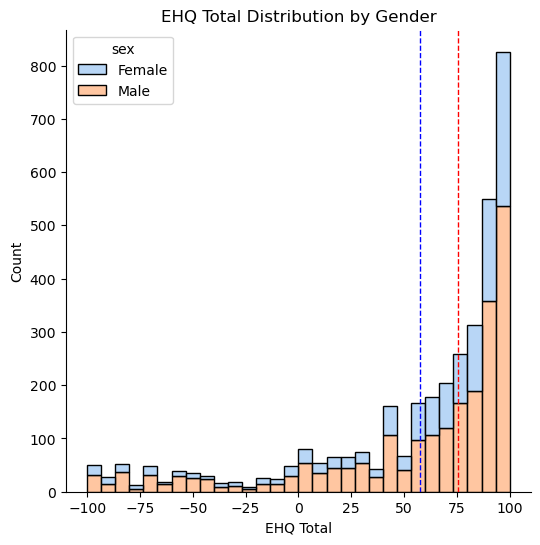

In [6]:
# Add histogram for ehq_total with gender as hue
plt.figure(figsize=(6, 6))
sns.histplot(data=demographic_data, x='ehq_total', hue='sex', multiple='stack',bins=30, palette='pastel')
# plot mean and median ehq_total
plt.axvline(demographic_data['ehq_total'].mean(), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(demographic_data['ehq_total'].median(), color='red', linestyle='dashed', linewidth=1)

plt.title('EHQ Total Distribution by Gender')
plt.xlabel('EHQ Total')
plt.ylabel('Count')
sns.despine()
# save the plot as pdf
# plt.savefig('funcs/ehq_total_distribution.pdf')
plt.show()

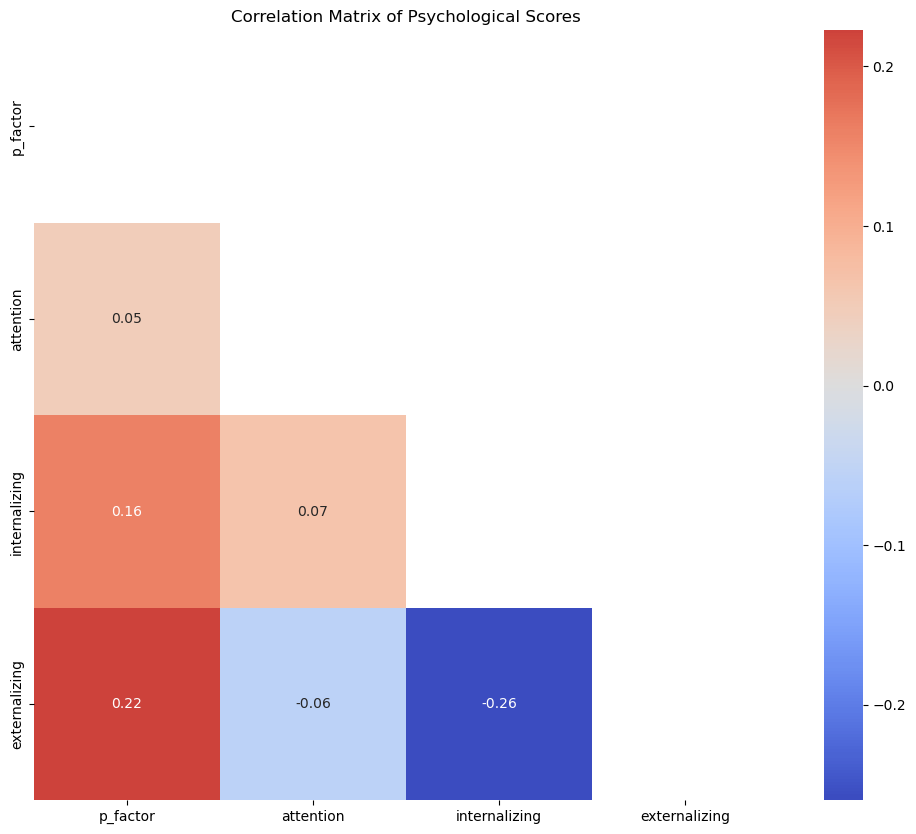

In [7]:
# Select relevant columns
selected_data = demographic_data[['p_factor', 'attention', 'internalizing', 'externalizing']]

# Compute the correlation matrix
corr_matrix = selected_data.corr()

# Create a mask to hide the upper triangle and diagonal
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Create a heatmap
plt.figure(figsize=(12, 10))  # Increase figure size
sns.heatmap(corr_matrix, annot=True, fmt='0.2f', cmap='coolwarm', center=0, mask=mask)
plt.title('Correlation Matrix of Psychological Scores')
# save the plot as pdf
# plt.savefig('funcs/correlation_matrix.pdf')
plt.show()


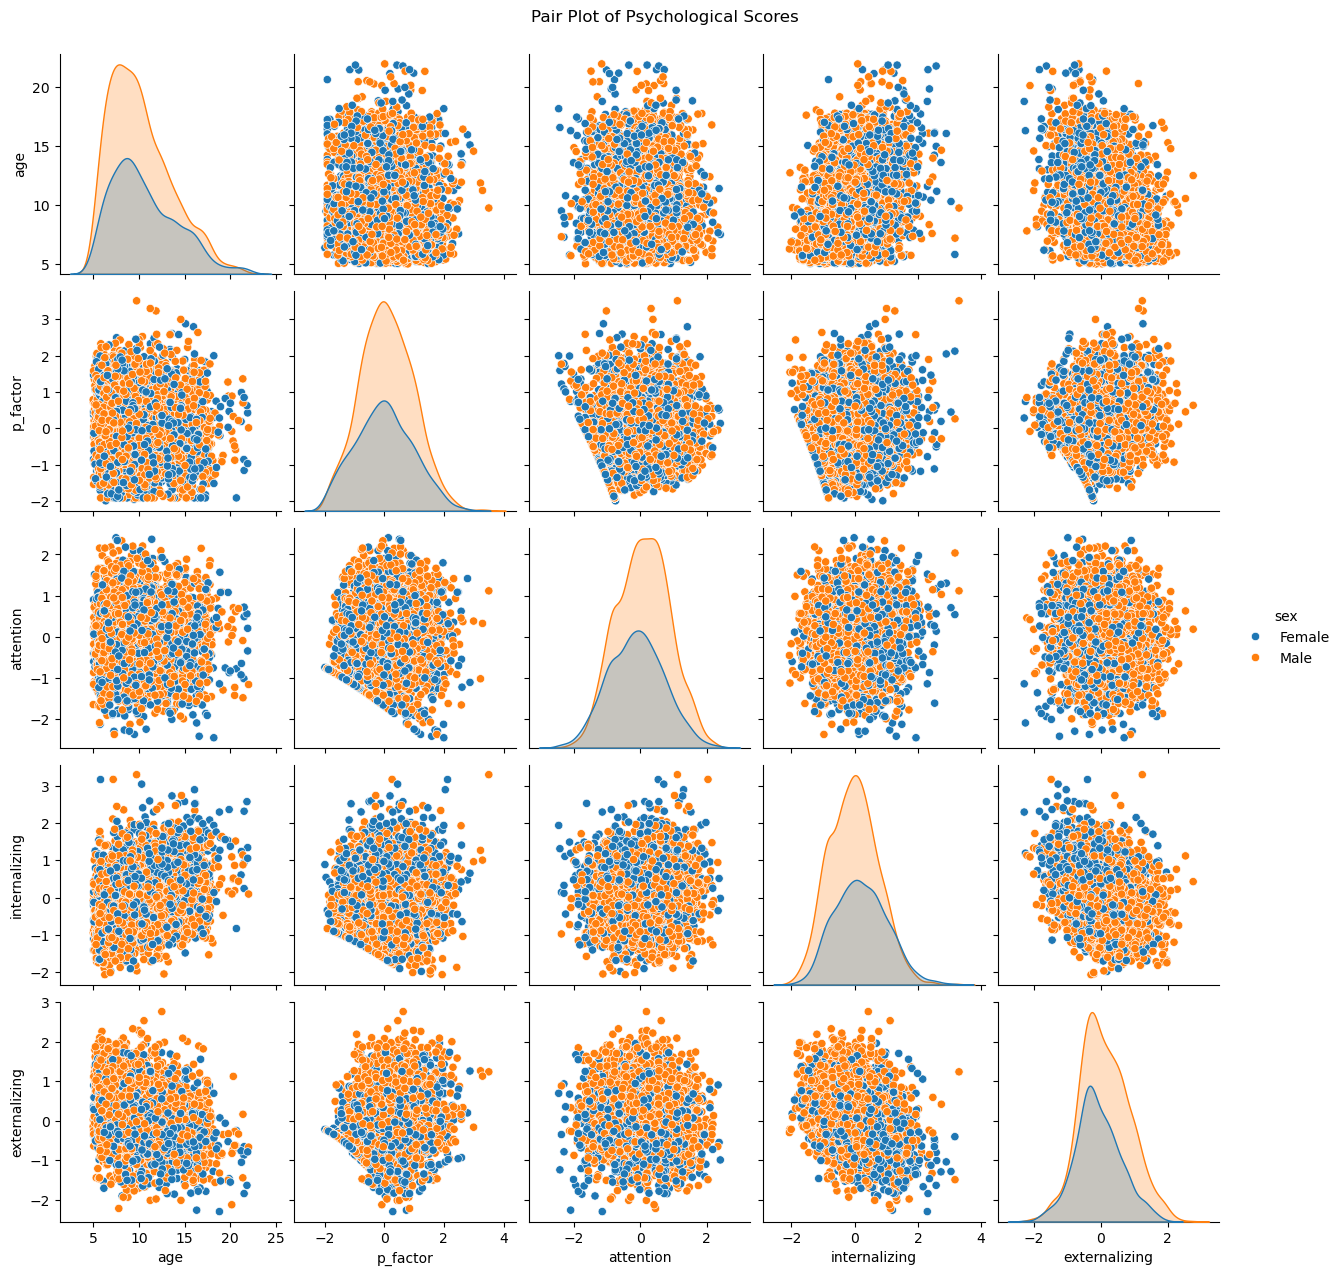

In [8]:
sns.pairplot(demographic_data, vars=['age', 'p_factor', 'attention', 'internalizing', 'externalizing'], hue='sex', diag_kind='kde')
plt.suptitle('Pair Plot of Psychological Scores', y=1.02)
# save the plot as pdf
# plt.savefig('funcs/pair_plot.pdf')
plt.show()

In [11]:
# PCA analysis to reduce dimensions
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Select variables for PCA
pca_data = demographic_data[['age', 'ehq_total', 'p_factor', 'attention', 'internalizing', 'externalizing']].copy()

# Remove rows with NaN values
pca_data_clean = pca_data.dropna()
gender_clean = demographic_data.loc[pca_data_clean.index, 'sex']

# Standardize the data (important for PCA)
scaler = StandardScaler()
pca_data_scaled = scaler.fit_transform(pca_data_clean)

# Apply PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(pca_data_scaled)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Gender'] = gender_clean.values

# Calculate explained variance
explained_variance = pca.explained_variance_ratio_ * 100

# Print the feature loadings for each principal component
loadings_df = pd.DataFrame(
    pca.components_.T, 
    columns=[f'PC{i+1} ({var:.1f}%)' for i, var in enumerate(explained_variance)],
    index=features
)
print('Feature loadings:')
print(loadings_df)

Feature loadings:
               PC1 (25.8%)  PC2 (19.7%)
age              -0.570343     0.005098
ehq_total        -0.139870    -0.144059
p_factor          0.111718     0.800063
attention        -0.081470     0.291032
internalizing    -0.556668     0.426010
externalizing     0.571093     0.270067


In [ ]:
# Create a figure with subplots for each factor
factors = ['age', 'ehq_total', 'p_factor', 'attention', 'internalizing', 'externalizing']
cmaps = ['viridis', 'magma', 'plasma', 'inferno', 'coolwarm', 'RdYlBu']  # different colormaps for each factor

# Set up 2x4 subplot grid
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

# First subplot: Gender scatter plot with KDE
for gender, color in zip(['Male', 'Female'], sns.color_palette('pastel', 2)):
    subset = pca_df[pca_df['Gender'] == gender]
    sns.kdeplot(x='PC1', y='PC2', data=subset, ax=axes[0], levels=5, fill=True, alpha=0.2,
                color=color, linewidths=1)
sns.scatterplot(x='PC1', y='PC2', hue='Gender', data=pca_df, alpha=0.7, s=50, ax=axes[0])
axes[0].set_title('PCA Distribution by Gender')
axes[0].set_xlabel(f'PC1 ({explained_variance[0]:.1f}%)')
axes[0].set_ylabel(f'PC2 ({explained_variance[1]:.1f}%)')
axes[0].legend(title='Gender')

# Second subplot: Feature loadings
features = pca_data_clean.columns
loadings = pca.components_.T
for i, feature in enumerate(features):
    axes[1].arrow(0, 0, -loadings[i, 0]*0.8, loadings[i, 1]*0.8, head_width=0.05, head_length=0.05, fc='blue', ec='blue')
    axes[1].text(-loadings[i, 0]*1.05, loadings[i, 1]*1.1, feature, color='black', ha='center', va='center')
axes[1].set_xlim(-1, 1)
axes[1].set_ylim(-1, 1)
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].set_title('PCA Feature Loadings')
axes[1].axhline(y=0, color='k', linestyle='-', alpha=0.3)
axes[1].axvline(x=0, color='k', linestyle='-', alpha=0.3)
axes[1].grid(alpha=0.3)

# Create remaining plots for each factor
for idx, (factor, cmap) in enumerate(zip(factors, cmaps)):
    ax = axes[idx+2]
    
    # Create scatter plot with factor color gradient
    scatter = ax.scatter(pca_df['PC1'], pca_df['PC2'],
                        c=pca_data_clean[factor],
                        cmap=cmap,
                        s=15,
                        alpha=0.6)
    
    # Add colorbar
    plt.colorbar(scatter, ax=ax, label=factor)
    
    # Add KDE contours
    sns.kdeplot(x='PC1', y='PC2', data=pca_df,
                levels=10,
                fill=True,
                alpha=0.1,
                color='gray',
                linewidths=0.5,
                ax=ax)
    
    # Customize each subplot
    ax.set_title(f'Distribution Colored by {factor}')
    ax.set_xlabel(f'PC1 ({explained_variance[0]:.1f}%)')
    ax.set_ylabel(f'PC2 ({explained_variance[1]:.1f}%)')
    ax.grid(True, alpha=0.2)

plt.tight_layout()
# plt.savefig('funcs/pca_factors_distribution.pdf')
plt.show()

# Print correlation between PC1, PC2 and each factor
print("\nCorrelations between PCs and factors:")
correlations = pd.DataFrame()
for factor in factors:
    corr_pc1 = np.corrcoef(pca_df['PC1'], pca_data_clean[factor])[0,1]
    corr_pc2 = np.corrcoef(pca_df['PC2'], pca_data_clean[factor])[0,1]
    correlations[factor] = [corr_pc1, corr_pc2]

correlations.index = ['PC1', 'PC2']
print(correlations.round(3))

/Users/yahya/miniconda3/envs/torch-sci/lib/python3.10/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
/Users/yahya/miniconda3/envs/torch-sci/lib/python3.10/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(


AttributeError: PathCollection.set() got an unexpected keyword argument 'hue'

/Users/yahya/miniconda3/envs/torch-sci/lib/python3.10/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
/Users/yahya/miniconda3/envs/torch-sci/lib/python3.10/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
/Users/yahya/miniconda3/envs/torch-sci/lib/python3.10/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
/Users/yahya/miniconda3/envs/torch-sci/lib/python3.10/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
/Users/yahya/miniconda3/envs/torch-sci/lib/python3.10/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
/Users/yahya/miniconda3/envs/torch-sci/lib/python3.10/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = 

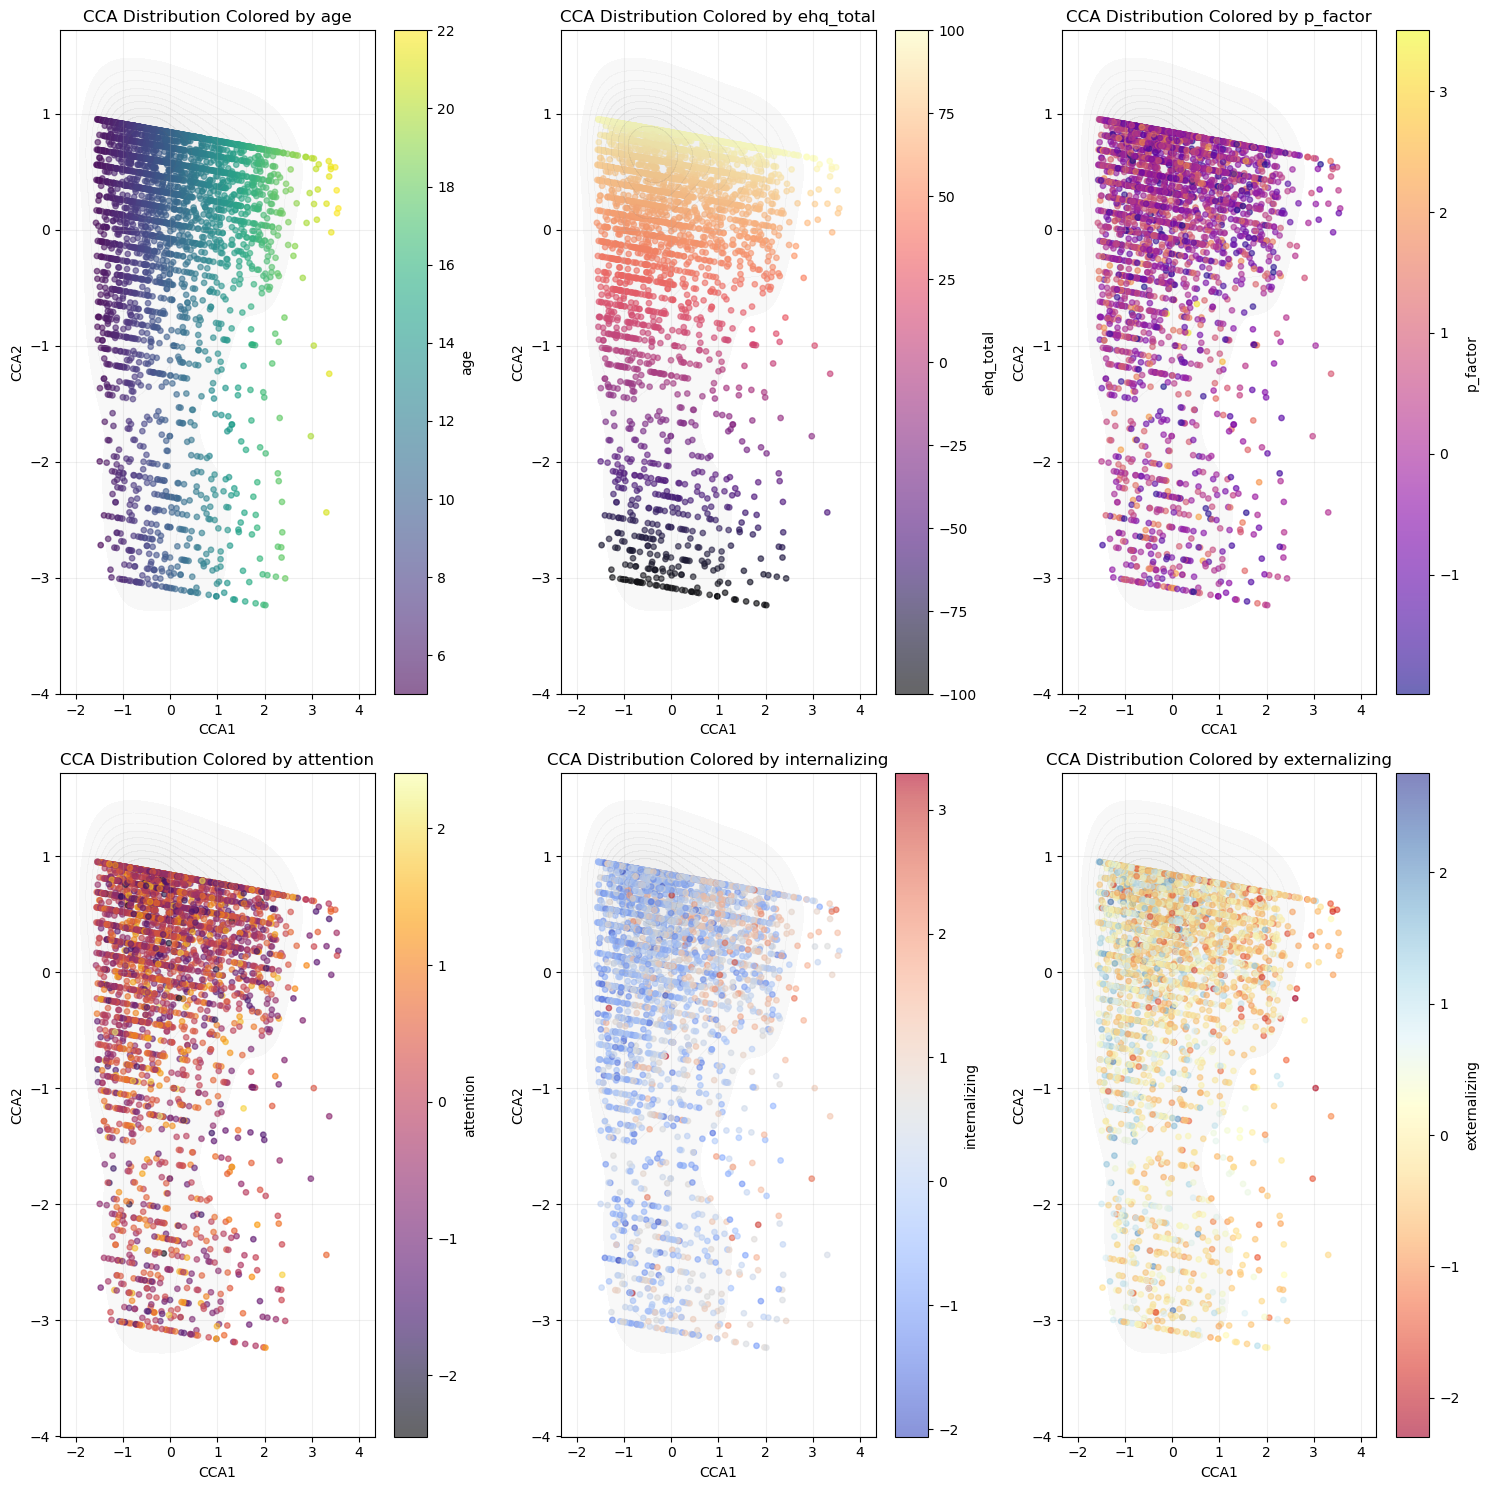

Correlations between first canonical variables: 0.34432386068138165
Correlations between second canonical variables: 0.03323069631706273


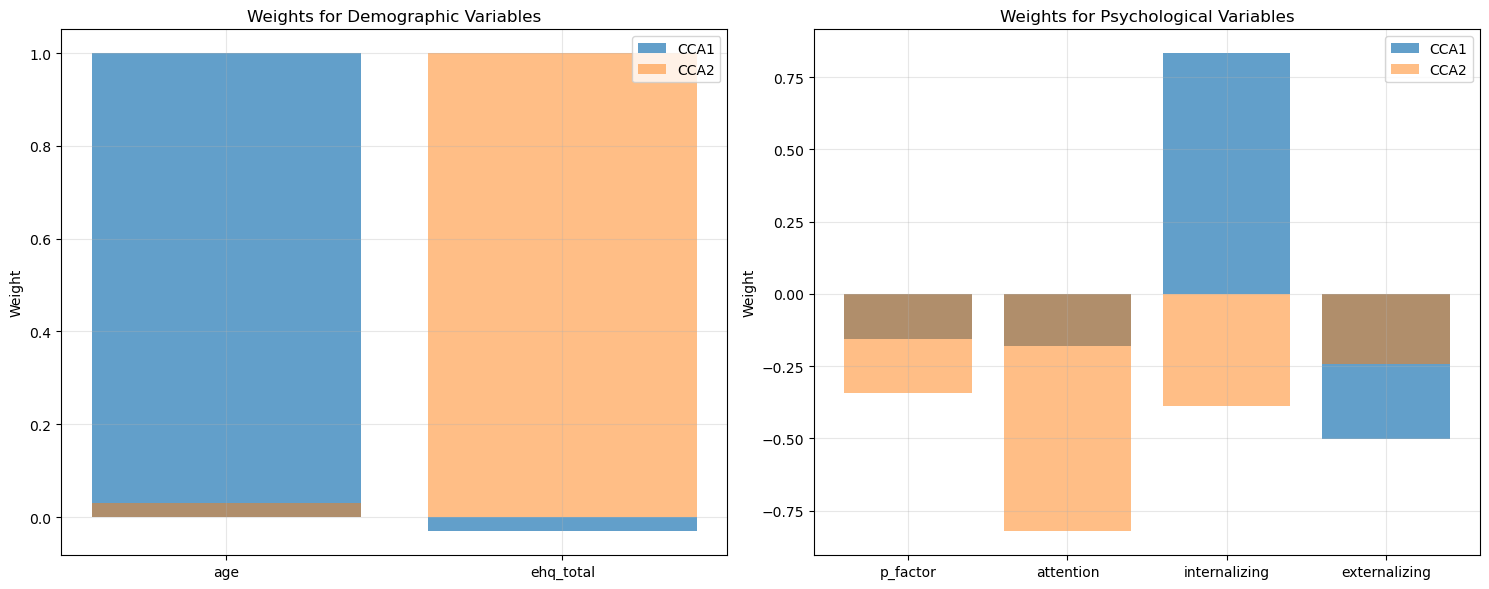

In [11]:
# CCA analysis for dimension reduction
from sklearn.cross_decomposition import CCA

# Divide variables into two sets for CCA
# Set 1: demographic variables
# Set 2: psychological variables
X1 = demographic_data[['age', 'ehq_total']].copy()
X2 = demographic_data[['p_factor', 'attention', 'internalizing', 'externalizing']].copy()

# Get common indices with no missing values
common_indices = X1.dropna().index.intersection(X2.dropna().index)
X1_clean = X1.loc[common_indices]
X2_clean = X2.loc[common_indices]
gender_clean = demographic_data.loc[common_indices, 'sex']

# Standardize the data
scaler1 = StandardScaler()
scaler2 = StandardScaler()
X1_scaled = scaler1.fit_transform(X1_clean)
X2_scaled = scaler2.fit_transform(X2_clean)

# Apply CCA
n_components = 2
cca = CCA(n_components=n_components)
cca.fit(X1_scaled, X2_scaled)

# Transform the data
X1_c, X2_c = cca.transform(X1_scaled, X2_scaled)

# Create DataFrames for plotting
cca_df = pd.DataFrame()
cca_df['CCA1'] = X1_c[:, 0]
cca_df['CCA2'] = X1_c[:, 1]
cca_df['Gender'] = gender_clean.values

# Get original variables for coloring
factors = ['age', 'ehq_total', 'p_factor', 'attention', 'internalizing', 'externalizing']
factor_values = demographic_data.loc[common_indices, factors]

# Create a figure with subplots for each factor
cmaps = ['viridis', 'magma', 'plasma', 'inferno', 'coolwarm', 'RdYlBu']
n_cols = 3
n_rows = (len(factors) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))
axes = axes.flatten()

# Create a plot for each factor
for idx, (factor, cmap) in enumerate(zip(factors, cmaps)):
    ax = axes[idx]
    
    # Create scatter plot with factor color gradient
    scatter = ax.scatter(cca_df['CCA1'], cca_df['CCA2'], 
                        c=factor_values[factor],
                        cmap=cmap,
                        s=15,
                        alpha=0.6)
    
    # Add colorbar
    plt.colorbar(scatter, ax=ax, label=factor)
    
    # Add KDE contours
    sns.kdeplot(x='CCA1', y='CCA2', data=cca_df,
                levels=10,
                fill=True,
                alpha=0.1,
                color='gray',
                linewidths=0.5,
                ax=ax)
    
    ax.set_title(f'CCA Distribution Colored by {factor}')
    ax.set_xlabel('CCA1')
    ax.set_ylabel('CCA2')
    ax.grid(True, alpha=0.2)

# Remove any empty subplots
for idx in range(len(factors), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

# Calculate and print correlations between canonical variables
print("Correlations between first canonical variables:", 
      np.corrcoef(X1_c[:, 0], X2_c[:, 0])[0, 1])
print("Correlations between second canonical variables:", 
      np.corrcoef(X1_c[:, 1], X2_c[:, 1])[0, 1])

# Create a separate plot to show weights
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot weights for the first set (demographic)
x1_weights = cca.x_weights_
x1_features = X1_clean.columns
ax1.bar(x1_features, x1_weights[:, 0], alpha=0.7, label='CCA1')
ax1.bar(x1_features, x1_weights[:, 1], alpha=0.5, label='CCA2')
ax1.set_title('Weights for Demographic Variables')
ax1.set_ylabel('Weight')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot weights for the second set (psychological)
x2_weights = cca.y_weights_
x2_features = X2_clean.columns
ax2.bar(x2_features, x2_weights[:, 0], alpha=0.7, label='CCA1')
ax2.bar(x2_features, x2_weights[:, 1], alpha=0.5, label='CCA2')
ax2.set_title('Weights for Psychological Variables')
ax2.set_ylabel('Weight')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()